Coding is done in Colab, and data is kept in Google Drive.

In [ ]:
# We need to mount data from a drive using the code below.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importing necessary packages
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
import glob
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models,datasets

In [ ]:
# walking through files to get every file's name and store it in variable 'img_list'.
img_list = []
for dir_name, _, file_name in os.walk('/content/drive/MyDrive/Waste trash model/Wadaba dataset'):
  for filename in file_name:
    img_list.append(os.path.join(dir_name,filename))

In [ ]:
# There are 4047 files in Wadaba dataset including image files and other annotations.
len(img_list)

4047

In [ ]:
# The Wadaba dataset separates the data into 20 distinct Sets. On the other hand, every file's name has the parent folder name or the number of sets in the form of 'Set 19' for example, followed by picture code 
# or two different files: 'f rename.exe' and rename.bat.
# Non-image files are separated into two classes based on their name character counts.
# The first group is that the 62s character is 'f' for f rename.exe or 'r' for rename.bat.
non_images62 = []
for file in img_list:
  if file[62] == 'f' or file[62] == 'r':
    non_images62.append(file)
non_images63 = []
for file in img_list:
  if file[63] == 'f' or file[63] == 'r':
    non_images63.append(file)

In [ ]:
# ther are 40 non image files.
non_images = non_images62 + non_images63
len(non_images)

40

In [ ]:
# lets remove non image files from our file names list.
for non_image in non_images:
  img_list.remove(non_image)

In [ ]:
# number of image files in wadaba dataset:
len(img_list)

4007

In [ ]:
#lets see an exmaple of file path in wadaba dataset
img_list[3900]

In [ ]:
# We split the information into two groups, each with a distinct set of character numbers, as we have done before.
# If you want to know how the data in wadaba has been labeled, you should read the corresponding document.
# I separated the plastic-type by addressing it as follows.
def get_class(img_paths):
  img_classes = []
  for image in img_paths:
    if image[61].isdigit():
      img_classes.append(image[69:71])
    else:
      img_classes.append(image[68:70])
  return img_classes

In [ ]:
classes = get_class(img_list)
len(classes)

4007

In [ ]:
# how the classes are stored in classes list
classes[400]

'05'

In [ ]:
# To clarify which plastic category each class belongs to, a dict was created.
class_dict = {0  : "miss",
1 : "PET",
2 : "PE-HD",
3 : "PVC",
4 : "PE-LD",
5 : "PP",
6 : "PS",
7 : "Other"}

In [ ]:
list(class_dict.keys())

[0, 1, 2, 3, 4, 5, 6, 7]

In [ ]:
# converting the labels from str to int.
int_labels = []
for str_label in classes:
  int_labels.append(int(str_label))

In [ ]:
# We split the data into training and test sets.
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(img_list, int_labels, shuffle = True, stratify= int_labels) #stratify data for niform distribution.

In [ ]:
# Determine the number of items of various categories that exist.import collections
import matplotlib.pyplot as plt
counter_tensor = collections.Counter(Y_test)
counter_tensor

Counter({2: 150, 6: 130, 1: 552, 5: 160, 7: 10})

In [ ]:
#  define transformations and augmentations for train and test data.
transformation = {
    'train' : transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(size = (224,224)),
        transforms.RandomRotation(degrees=[-180,180])
    ]),
    'test' : transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(size = (224,224))
    ])
}

In [ ]:
# specify dataset class inherited from pytorch Dataset class.
class wadaba_dataset(Dataset):
    def __init__(self,img_paths, labels, transform = None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return(len(self.labels))
    def __getitem__(self,index):
        image = Image.open(self.img_paths[index]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.labels[index]
        return image, label

In [ ]:
# train and test dataset objects created.
train_dataset = wadaba_dataset(X_train, Y_train, transform=transformation['train'])
test_dataset = wadaba_dataset(X_test, Y_test, transform=transformation['test'])

In [ ]:
# train adn test dataloader created.
train_dataloader = DataLoader(train_dataset, batch_size= 4, shuffle=True, num_workers= 4)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers= 4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


PET


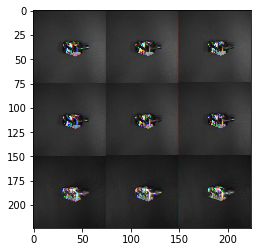

In [ ]:
# showing a single data with its label.
import matplotlib.pyplot as plt
x, y = next(iter(test_dataloader))
plt.imshow(x[3].reshape(224,224,3), cmap = 'gray');
print(class_dict[int(y[3])]);

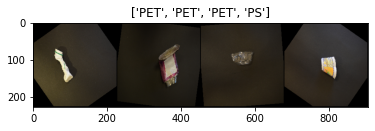

In [ ]:
# creating imshow function to show a batch of dataloaders
def imshow(inp, title = None):
  inp = inp.numpy().transpose((1,2,0))
  inp = np.clip(inp, 0,1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

Xs, Ys = next(iter(train_dataloader))
out = torchvision.utils.make_grid(Xs)
imshow(out, title = [class_dict[int(i)] for i in Ys])

In [ ]:
# create a model object based on resnet50
# pretrained is True to get pretraind parameters based on Imagenet
resnet = models.resnet50(pretrained = True)
resnet

In [ ]:
# change fully connected block and specifying it for our network
resnet.fc = nn.Sequential(
    nn.Linear(in_features=2048, out_features= 1024),
    nn.ReLU(),
    nn.Linear(in_features=1024, out_features= 512),
    nn.ReLU(),
    nn.Dropout(0.6),
    nn.Linear(in_features= 512, out_features=8),
    nn.LogSoftmax(dim=1)
)

In [ ]:
# creating a function accuracy for calcualting accuracy if we pass outputs and labels
def accuracy(outputs, labels):
  _,preds = torch.max(outputs, dim= 1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
# creating an object of out resnet named model
model = resnet

In [ ]:
# a function to check if GPU is availibale or not
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [ ]:
# check what proccessor unit is availible.
device = get_default_device()
device

device(type='cpu')

In [ ]:
#  a function to pass our model or data to availible device.
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)

In [ ]:
model = to_device(model, device)

In [ ]:
#  check the model in cuda device
model.cuda()

In [ ]:
# summing up everything we need in related dictionaries.
dataloaders = {
    'train' : train_dataloader,
    'val' : test_dataloader
}

batch_size = {
    'train' : 32,
    'val' : 32
}

logging_step = {
    'train' : len(dataloaders['train']) // 10,
    'val' : len(dataloaders['val']) // 10
}

dataset_sizes = {
    'train' : len(train_dataset),
    'val' : len(test_dataset)
} 
epoch = 1

optimizer_ft = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [ ]:
# importing other needed libraries
# creating train function to train our model then.
import time
from tqdm.auto import tqdm
import copy
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs), leave= False ):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase], leave = False,
                                            total = len(dataloaders[phase])):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# a function to show sum examles and their prediction by the model.
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2+1, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_dict[int(preds[j])]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
# freezing all layers except fully connected layers.
model_conv = resnet
for param in model_conv.parameters():
    param.requires_grad = False

model_conv.fc = nn.Sequential(
    nn.Linear(in_features=2048, out_features= 1024),
    nn.ReLU(),
    nn.Linear(in_features=1024, out_features= 512),
    nn.ReLU(),
    nn.Dropout(0.6),
    nn.Linear(in_features= 512, out_features=8),
    nn.LogSoftmax(dim=1)
)

optimizer_conv = optim.SGD(model_conv.parameters(), lr = 0.001, momentum= 0.9)

In [ ]:
# passing the model to our device.(GPU or CPU)
model_conv.to(device)

In [ ]:
# transfer learning train for 5 epochs
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=5)

val Loss: 0.7099 Acc: 0.7315

Epoch 3/4
----------


  0%|          | 0/752 [00:00<?, ?it/s]

train Loss: 0.7713 Acc: 0.6932


  0%|          | 0/251 [00:00<?, ?it/s]

val Loss: 0.8551 Acc: 0.6916

Epoch 4/4
----------


  0%|          | 0/752 [00:00<?, ?it/s]

train Loss: 0.7097 Acc: 0.7195


  0%|          | 0/251 [00:00<?, ?it/s]

val Loss: 0.5891 Acc: 0.7595

Training complete in 23m 24s
Best val Acc: 0.759481


In [ ]:
# transfer learning train for 5 more epochs
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=5)

val Loss: 0.4631 Acc: 0.8164

Epoch 3/4
----------


  0%|          | 0/752 [00:00<?, ?it/s]

train Loss: 0.6936 Acc: 0.7304


  0%|          | 0/251 [00:00<?, ?it/s]

val Loss: 0.4835 Acc: 0.8054

Epoch 4/4
----------


  0%|          | 0/752 [00:00<?, ?it/s]

train Loss: 0.6875 Acc: 0.7218


  0%|          | 0/251 [00:00<?, ?it/s]

val Loss: 0.4431 Acc: 0.8174

Training complete in 24m 9s
Best val Acc: 0.817365


In [ ]:
# transfer learning train for 2 epochs
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=2)

val Loss: 0.5565 Acc: 0.7854

Training complete in 9m 26s
Best val Acc: 0.785429


In [ ]:
# I saved the trained model here and leave the training for a while
model_save_name = '12 epoch transfer learned.pt'
path = F"/content/drive/MyDrive/Waste trash model/{model_save_name}" 
torch.save(model_conv.state_dict(), path)

In [ ]:
# I loaded the trained parameters and started to training for few epochs
model_load_name = '17 epoch transfer learned.pt'
path = F"/content/drive/MyDrive/Waste trash model/{model_load_name}"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
# when we want to fine tune all layers and parameters not only fully connecteds.
for param in model.parameters():
  param.require_grad = True

In [ ]:
# trainig five more epochs for fine tuning after enabling every parameters grad True.
Ft_model = train_model(model, criterion, optimizer_ft,exp_lr_scheduler, num_epochs = 5)

In [ ]:
# save new model after 17 epoch of training.
model_save_name = '17 epoch transfer learned.pt'
path = F"/content/drive/MyDrive/Waste trash model/{model_save_name}"
torch.save(Ft_model.state_dict(), path)

In [ ]:
model_load_name = '17 epoch transfer learned.pt'
path = F"/content/drive/MyDrive/Waste trash model/{model_load_name}"
model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

<All keys matched successfully>

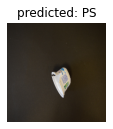

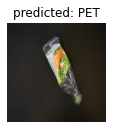

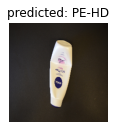

In [ ]:
# manual check the model for 3 images.
visualize_model(model, num_images=3)

In [ ]:
# load onnx packages for onnx format
import torch.onnx

In [ ]:
# creating onnx format of trained model.
model.eval()
batch_size = 1
x = torch.randn(batch_size, 3, 224, 224, requires_grad=True)
torch.onnx.export(model,
                  x,
                  '/content/drive/MyDrive/Waste trash model/firstONNX.onnx',
                  export_params= True,
                  opset_version = 10,
                  do_constant_folding = True,
                  input_names = ['input'],
                  output_names = ['output'],
                  dynamic_axes = {'input' : {0 : 'batch_size'}, 
                                'output' : {0 : 'batch_size'}})

In [ ]:
# calculating accuracy by cross-validation

corrects = 0
for inputs, labels in tqdm(test_dataloader, leave = False, total = len(test_dataloader)):
  inputs = inputs.to(device)
  labels = labels.to(device)
  outputs = model(inputs)
  _, preds = torch.max(outputs, 1)
  corrects += torch.sum(preds == labels.data)
acc = corrects.double() / len(test_dataset)


  0%|          | 0/251 [00:00<?, ?it/s]

In [ ]:
acc

tensor(0.9541, dtype=torch.float64)